# Runtime Setup

In [1]:
%load_ext autoreload
%autoreload 2

# Path Setup

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/Food\ Property\ Prediction

/content/drive/MyDrive/Food Property Prediction


In [ ]:
!pwd

/content/drive/MyDrive/Food Property Prediction


# Load Dataset

In [ ]:
from src.dataset import FoodPredictionDataset
from matplotlib import pyplot as plt

In [ ]:
food_dataset = FoodPredictionDataset(root_dir="ECUSTFD-resized-", mode="train")

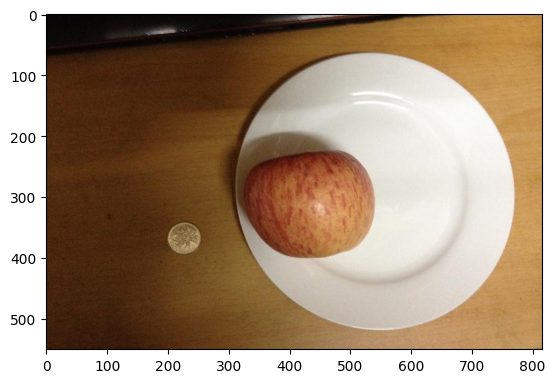

[[326 229]
 [540 401]]
310


In [ ]:
for i in range(len(food_dataset)):
    sample = food_dataset[i]
    plt.imshow(sample['image'])
    plt.show()
    print(sample['landmarks'])
    print(sample['volume'])
    break

# DataLoader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
dataloader = DataLoader(food_dataset, batch_size=4, shuffle=True, num_workers=0)

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched['volume'])
    break

tensor([210, 170, 420, 210])


# Object Detection & Segmentation

In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-aydvdge6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-aydvdge6
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5de5319a49e7ea819586d3d6a817632392dfdeb2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from detectron2 import model_zoo
from google.colab.patches import cv2_imshow

In [ ]:
# Create config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(food_dataset[0]['image'])

In [ ]:
outputs

{'instances': Instances(num_instances=0, image_height=551, image_width=816, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 551, 816), dtype=torch.bool)])}

In [ ]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

namespace(name='coco_2017_train',
          json_file='datasets/coco/annotations/instances_train2017.json',
          image_root='datasets/coco/train2017',
          evaluator_type='coco',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             13: 11,
                                             14: 12,
                                             15: 13,
                                             16: 14,
                                   

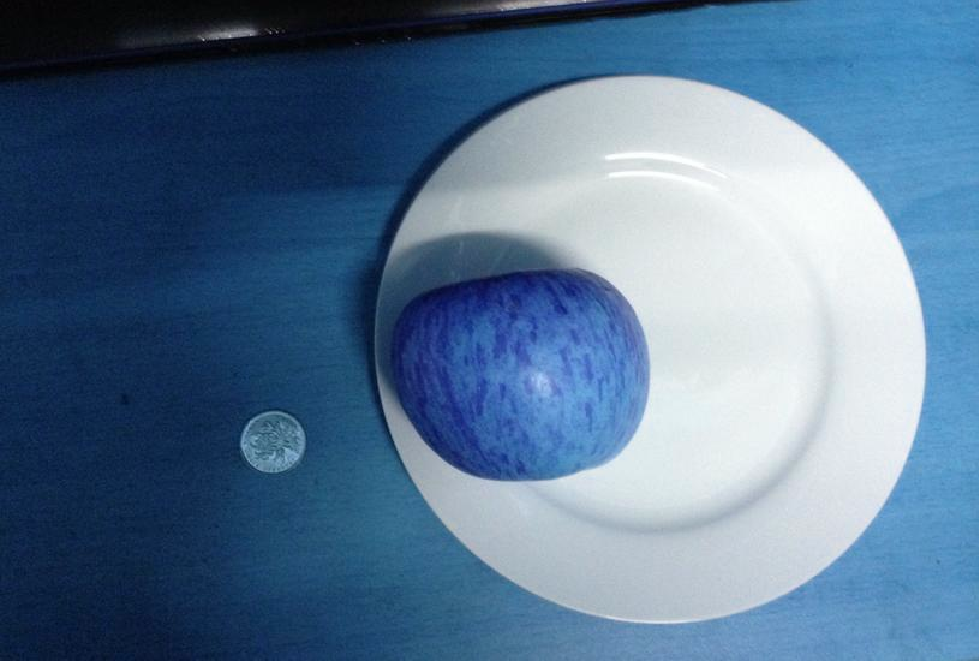

In [ ]:
v = Visualizer(
    food_dataset[0]['image'][:, :, ::-1],
    MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
    scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])